# Фанфикшн и тематическое моделирование
## Почему фанфикшн?
Хотя фанфикшн (фанатская литература) появилась еще до появления Интернета, распространяясь в небольших фанатских изданиях, сейчас сложно представить этот вид литературы (некоторые исследователи называют это паралитературой, другие считают разновидностью постфольклора) вне Интернета. Это делает его очень привлекательным для анализа - тексты уже сразу же рождаются в цифровом формате, а также, как правило, снабжены так называемой "шапкой" - метаданными. Эти метаданные сообщают фандом, возрастной рейтинг, направленность (например, Слэш - гомосексуальные отношения). Эти метаданные интересны, так как создаются самими участниками сообщества фикрайтеров. 
## Что мы делаем?
Предположим, что мы хотим узнать как связаны часть такой шапки - жанр - с содержанием самих текстов. Для начала нам надо собрать корпус текстов с метаданными. Корпус можно балансировать по разным принципам, в нашем случае мы берем по сто текстов четырех направленностой для каждого из четырех жанров (Ангст, Флафф, Фэнтези и Повседневность), всего 1600 текстов. Важно понимать, что каждый из этих текстов относится и к другим жанрам (как правило все тексты имеют больше одной жанровой метки), в нашем случае важно, что тексты в наших четырех жанрах не пересекаются между собой (то есть, мы исключили тексты, присутсвующие в более чем одном из этих четырех жанров). 
## Для чего нужно тематическое моделирование?
Как же атоматически определить содержание этих текстов? Одним из популярных способов для этого является тематическое моделирование. По существу, оно позволяет выделять из текстов темы, с какой-то вероятностью порождающие слова и затем смотреть, с какую вероятностью тексты соотносятся с этими темами. Для нашей задачи мы будем применять тематическое моделирование, основанное на Латентном размещении Дирихле ([подробнее прочитать про это можно здесь](https://sysblok.ru/knowhow/kak-ponjat-o-chem-tekst-ne-chitaja-ego/)). Так как нужные алгоритмы уже имплементированы в Питоне, математика, стоящая за ними, нас беспокоить не будет.

Датасет с текстами можно найти на этом [гугл-диске](https://drive.google.com/drive/folders/1uEnZJDzty2u0h9O1pdhPHcUIzeWss8xI?usp=sharing). Функцию для скачивания и другие материалы можно увидеть по [ссылке](https://github.com/makarfedorov/topic_modeling_paraliterature). Для того, чтобы код заработал, необходимо загрузить датасет к себе на диск и заменить путь к файлу в переменной adress на путь к файлу на своем диске. Следует заметить, что pandas не является стандартной библиотекой для Питона и его следует устанавливать, если вы не работаете в Колабе - здесь эта библиотека уже предустановлена

In [ ]:
!pip install pyldavis
import os
import pandas as pd
address = "/content/drive/MyDrive/ficbook_one_file/corpus_fanfic.csv"
fanfic_data = pd.read_csv(adress)
os.chdir("/content")

Посмотрим на наши данные

In [ ]:
fanfic_data.head()

,Unnamed: 0,id,author,title,link,description,tag,likes,date,review,size,text,rating,parts,romance,fandom,genre,page
0,0,1,Olivia,Герои недописанных историй,/readfic/1920934,"Герои недописанных историй,\r\nзамерзшие во л...","Ангст,Драма,Стихи",13474,2014-04-28,1118,162,"Герои недописанных историй,\r\nЗамерзшие во ль...",G,Нет,Джен,Ориджиналы,Ангст,1
1,1,2,Джoкер,О войне писали много,/readfic/1743853,"Прах от тел, скелеты зданий,\r\nЛес сгоревший ...","Ангст,Драббл,Стихи",6621,2014-03-05,432,138,"О войне писали много,\r\nКак летит на землю пл...",G,Нет,Джен,Ориджиналы,Ангст,1
2,2,3,лунный мечтатель полтергейста,Невыносимое создание,/readfic/8603938,У мальчишки Поттера глаза его деда и та же при...,"AU,Ангст,Детская влюбленность,Дружба,Наставнич...",5398,2019-09-03,97,1586,- Ты! Ты украл у меня слугу! \r\n Л...,PG-13,Нет,Джен,"Роулинг Джоан «Гарри Поттер»,Гарри Поттер",Ангст,1
3,3,4,Хана_Вишнёвая,Ангелы падают,/readfic/1119388,Серый асфальт – конечная.,"Ангст,Драббл,Стихи,Эксперимент",5217,2013-08-19,181,127,Ангелы падают.\r\nАнгелы падают вниз.\r\nКрыль...,G,Нет,Джен,Ориджиналы,Ангст,1
4,4,5,LuckyLuke,Меня зовут Сэм,/readfic/3911101,"Меня зовут Сэм. Вернее, звали - в последней жи...","Hurt/Comfort,Ангст,Соулмейты,Эксперимент",4883,2015-12-29,403,3432,"Меня зовут Сэм. Вернее, звали — в последней жи...",R,Нет,Джен,Ориджиналы,Ангст,1


Для начала загрузим токенайзер и пунктуацию из библиотеки **nltk**. Кроме этого нам понадобится список стоп-слов 

In [ ]:
from nltk.tokenize import word_tokenize 
from nltk import download as nltk_download 

nltk_download("punkt")
!wget https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt
with open ("stop_ru.txt", "r") as stop_ru:
    rus_stops = [word.strip() for word in stop_ru.readlines()]
punctuation = '!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~—»«...–'    
filter = rus_stops + list (punctuation)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
--2022-01-14 17:03:53--  https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5823 (5.7K) [text/plain]
Saving to: ‘stop_ru.txt.2’

stop_ru.txt.2       100%[===================>]   5.69K  --.-KB/s    in 0s      

2022-01-14 17:03:53 (67.9 MB/s) - ‘stop_ru.txt.2’ saved [5823/5823]



Теперь установим лемматизатор, для этой цели подойдет библиотека **pymorphy2**. С помощью нее можно приводить слова в начальную форму (программа может приводить в том числе те слова, которые ей "незнакомы")

In [ ]:
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer

parser = MorphAnalyzer()

Напишем функцию для предобработки текста. Слова приводятся к нижнему регистру, стоп-слова удаляются, далее слова лемматизируются



In [ ]:
def preprocess(input_text):
    """
    Функция для предобработки текста. Слова приводятся к нижнему регистру,
    стоп-слова удаляются, далее слова лемматизируются
    :param input_text: Входной текст для очистки и лемматизации
    :return: Очищенный и лемматизированный текст
    """
    text = input_text.lower()
    tokenized_text = word_tokenize(text)
    clean_text = [word for word in tokenized_text if word not in filter]
    lemmatized_text = [parser.parse(word)[0].normal_form for word in 
                       clean_text]
    
    return lemmatized_text

Теперь можно применить эту функцию к нашему датасету с текстами.Это лучше всего сделать с помощью функции **map** (или **apply**), которая может применить созданную нами функцию к каждому полю с текстом в таблице

In [ ]:
fanfic_data["text_processed"] = fanfic_data["text"].map(preprocess)
fanfic_data.head()

,Unnamed: 0,id,author,title,link,description,tag,likes,date,review,size,text,rating,parts,romance,fandom,genre,page,text_processed
0,0,1,Olivia,Герои недописанных историй,/readfic/1920934,"Герои недописанных историй,\r\nзамерзшие во л...","Ангст,Драма,Стихи",13474,2014-04-28,1118,162,"Герои недописанных историй,\r\nЗамерзшие во ль...",G,Нет,Джен,Ориджиналы,Ангст,1,"[герой, недописанный, история, замёрзнуть, лёд..."
1,1,2,Джoкер,О войне писали много,/readfic/1743853,"Прах от тел, скелеты зданий,\r\nЛес сгоревший ...","Ангст,Драббл,Стихи",6621,2014-03-05,432,138,"О войне писали много,\r\nКак летит на землю пл...",G,Нет,Джен,Ориджиналы,Ангст,1,"[война, писать, лететь, земля, пламень, миг, с..."
2,2,3,лунный мечтатель полтергейста,Невыносимое создание,/readfic/8603938,У мальчишки Поттера глаза его деда и та же при...,"AU,Ангст,Детская влюбленность,Дружба,Наставнич...",5398,2019-09-03,97,1586,- Ты! Ты украл у меня слугу! \r\n Л...,PG-13,Нет,Джен,"Роулинг Джоан «Гарри Поттер»,Гарри Поттер",Ангст,1,"[украсть, слуга, люциус, хвататься, палочка, ж..."
3,3,4,Хана_Вишнёвая,Ангелы падают,/readfic/1119388,Серый асфальт – конечная.,"Ангст,Драббл,Стихи,Эксперимент",5217,2013-08-19,181,127,Ангелы падают.\r\nАнгелы падают вниз.\r\nКрыль...,G,Нет,Джен,Ориджиналы,Ангст,1,"[ангел, падать, ангел, падать, крыло, держать,..."
4,4,5,LuckyLuke,Меня зовут Сэм,/readfic/3911101,"Меня зовут Сэм. Вернее, звали - в последней жи...","Hurt/Comfort,Ангст,Соулмейты,Эксперимент",4883,2015-12-29,403,3432,"Меня зовут Сэм. Вернее, звали — в последней жи...",R,Нет,Джен,Ориджиналы,Ангст,1,"[звать, сэм, верный, звать, последний, жизнь, ..."


Перед тем как делать собственно тематическое моделирование стоит посмотреть какие фандомы есть в дата-сете. Видно, что, во-первых, там есть отдельные фандомы для книг/фильмов по ним. Во-вторых, есть много разных комбинаций из фандомов франшизы Марвел (отдельный фандом для "Первого мстителя", "Железного человека" и т.д.)  и тому подобного. 

In [ ]:
fanfic_data["fandom"].unique()
# Роулинг Джоан «Гарри Поттер»,Гарри Поттер', Железный человек,Мстители,Человек-паук: Возвращение домой,  Вдали от дома', 'Железный человек,Первый мститель,Человек-паук: Возвращение домой,  Вдали от дома
# 'Железный человек,Первый мститель,Доктор Стрэндж,Человек-паук: Возвращение домой,  Вдали от дома',

array(['Ориджиналы', 'Роулинг Джоан «Гарри Поттер»,Гарри Поттер',
       'Фикбук и всё, что с ним связано',
       'Железный человек,Мстители,Человек-паук: Возвращение домой,  Вдали от дома',
       'Железный человек,Первый мститель,Человек-паук: Возвращение домой,  Вдали от дома',
       'Hetalia: Axis Powers',
       'Сверхъестественное,Доктор Кто,Шерлок (BBC),Мерлин,Отбросы,Теория Большого взрыва,Однажды в сказке,Американская история ужасов,Ходячие мертвецы,Ганнибал',
       'Железный человек,Мстители,Первый мститель,Человек-паук: Возвращение домой,  Вдали от дома',
       'Звездные Войны', 'Katekyo Hitman Reborn!',
       'Железный человек,Первый мститель,Доктор Стрэндж,Человек-паук: Возвращение домой,  Вдали от дома',
       'Роулинг Джоан «Гарри Поттер»', 'Сверхъестественное', 'Death Note',
       'Тор,Железный человек,Мстители,Первый мститель,Доктор Стрэндж,Человек-паук: Возвращение домой,  Вдали от дома,Черная Пантера',
       'Bleach,Katekyo Hitman Reborn!', 'Bleach',
       '

Все эти фандомы необходимо стандартизовать, иначе их получится слишком много для исследования их связи с темами. Это можно сделать выбрав одну название для группы фандомов, которые мы будем считать единым фандомов, и просто заменяя все название на одно. Например, "Властелин колец", "Толкин Джон Р.Р. «Властелин колец»" и "Хоббит" становятся просто "Властелином Колец". Далее можно посмотреть 10 самых частотных фандомов, которые останутся как есть. Остальные низкочастотные фандомы будут помечены либо как "прочее" (если таковой присутствует отдельно), либо как "кроссовер" (если там несколько фандомов). Важно понимать, что функция для стандартизации фандомов работает только с конкетными фандомами, которые есть в нашем датасете. Для другого датасета пришлось бы делать иную стандартизацию (даже если набор фандомов сильно не отличается, их частотности могут быть другими, а значит, список из 10 самых частотных фандомов может быть другим)

In [ ]:
def standart(fandoms):
    """
    Функция для стандартизации фандомов
    :param fandoms: исходный список фандомов
    :return: стандартизованный фандом
    """
    fandom_dictionary = {"Роулинг Джоан «Гарри Поттер»":"Гарри Поттер", 
                         "Первый мститель":"Марвел", 
                         "Железный человек":"Марвел",
                         "Человек-паук: Возвращение домой,  Вдали от дома":"Марвел",
                         "Доктор Стрэндж":"Марвел", 
                         "Толкин Джон Р.Р. «Властелин колец»":"Властелин Колец", 
                         "Тор":"Марвел", 
                         "Толкин Джон Р. Р. «Хоббит, или Туда и обратно»":"Властелин Колец",
                         "Капитан Марвел":"Марвел", 
                         "Сапковский Анджей «Ведьмак» (Сага о ведьмаке)":"Ведьмак",
                         "The Witcher":"Ведьмак",
                         "Мартин Джордж «Песнь Льда и Пламени»":"Игра Престолов",
                         "Boruto: Naruto Next Generations":"Naruto",
                         "Коллинз Сьюзен «Голодные игры»":"Голодные игры",
                         "Удивительный Человек-паук":"Марвел",
                         "Доктор Стрэндж и тайна Ордена магов":"Марвел",
                         "Фантастические твари":"Гарри Поттер",
                         "Marvel Comics":"Марвел","Тор,Доктор Стрэндж":"Марвел",
                         "Мстители,Доктор Стрэндж":"Марвел",
                         "Дэдпул,Дэдпул":"Марвел",
                         "Черная Пантера":"Марвел", "  Вдали от дома":"Марвел",
                         "Мстители":"Марвел", "Новый Человек-паук":"Марвел",
                         "Человек-паук: Возвращение домой":"Марвел",
                         "Человек-Паук":"Марвел", "Хоббит":"Властелин Колец",
                         "Человек-паук: Через Вселенные":"Марвел",
                         "Человек-паук":"Марвел", "Веном":"Марвел",
                         "Стражи Галактики":"Марвел", "Дэдпул":"Марвел",
                         "Черная вдова":"Марвел", "Халк":"Марвел"}
    sig_list = ["Ориджиналы", "Гарри Поттер", "Марвел", 
                "Чудесная божья коровка (Леди Баг и Супер-Кот)", 
                "Bangtan Boys (BTS)",
                "Однажды в сказке","Fairy Tail", "Сотня", "Naruto", "Волчонок"]
    
    standart_fandoms = []
    fandoms = fandoms.split(",")
    for fandom in fandoms:
        if fandom in fandom_dictionary:
            fandom = fandom_dictionary[fandom]
        if fandom in sig_list:
            standart_fandoms.append(fandom)
        else: 
            standart_fandoms.append("Прочее")          
    
    final = list(set(standart_fandoms)) 
    if len(final) > 1:
        final = "Кроссовер"
    else:
        final = final[0]
    
    return final                        

Можно посмотреть на количество стандартизированных фандомов и, на всякий случай, сохранить их в отдельный файл

In [ ]:
fanfic_data["standart_fandom"] = fanfic_data["fandom"].apply(standart)
fandoms = fanfic_data["standart_fandom"].value_counts()
print(fandoms)
fandoms.to_csv("fandoms3.csv")

Ориджиналы                                       437
Прочее                                           343
Гарри Поттер                                     196
Марвел                                           167
Чудесная божья коровка (Леди Баг и Супер-Кот)     99
Bangtan Boys (BTS)                                79
Однажды в сказке                                  61
Кроссовер                                         52
Fairy Tail                                        47
Сотня                                             45
Naruto                                            39
Волчонок                                          35
Name: standart_fandom, dtype: int64


Надо импортировать библиотеку **gensim**. Затем мы создаем словарь для тематического моделирования из лемматизированного текста. После создания словаря лучше всего отфлильтровать те слова, которые встречаются в слишком большом количестве текстов, и те, которые встречаются в слишком маленьком количество текстов. Для этого есть метод **filter_extremes**, который принимает в себя аргументы **no_above** (только слова, которые встречаются не более, чем в указанной доле текстов) и **no_below=20** (слова, которые встречаются не менее чем в указанном количестве текстов). После удаления лищних слов, словарь лучше всего ужать в размерах, убрав пропуски с помощью метода **compactify**.

In [ ]:
import gensim
gensim_dictionary = gensim.corpora.Dictionary(fanfic_data["text_processed"])
gensim_dictionary.filter_extremes(no_above=0.1, no_below=20)
gensim_dictionary.compactify()

print(gensim_dictionary)

Dictionary(8488 unique tokens: ['архив', 'градус', 'забытый', 'замёрзнуть', 'зимний']...)


**Теперь** создаем корпус в виде "мешка слов" (bag of words)

In [ ]:
corpus = [gensim_dictionary.doc2bow(text) 
          for text in fanfic_data['text_processed']]

Теперь можно сделать само тематическое моделирование. Для этого, помимо созданного корпуса и словаря, необходимо указать количество "обходов", которые будет делать алгоритм (чем больше, тем точнее и медленнее сооздаваться будет модель) и количество тем, которые мы хотим выделить. Пока возьмем 20 тем (еще стоит не забыть установить **random_state** на какое-нибудь число - это позволит восстановить результат)

In [ ]:
lda_20 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=20, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=6457)

Тематическое моделирование для 20 тем (с помощью Латентного размещения Дирихле)

In [ ]:
lda_20.print_topics()

fw = open("topics_20.txt", "w", encoding="utf-8")
for topic in lda_20.print_topics():
    fw.write(str(topic)) 
    print(str(topic))
fw.close()    

(0, '0.018*"мститель" + 0.018*"стив" + 0.013*"старка" + 0.010*"паркер" + 0.008*"пятница" + 0.008*"наташа" + 0.007*"паучок" + 0.007*"флэш" + 0.005*"бак" + 0.005*"паук"')
(1, '0.047*"кларк" + 0.036*"лекса" + 0.025*"люси" + 0.014*"лекс" + 0.013*"гриффин" + 0.012*"наца" + 0.009*"леви" + 0.008*"дракон" + 0.008*"гильдия" + 0.006*"брюнетка"')
(2, '0.002*"волк" + 0.002*"сигарета" + 0.002*"мужик" + 0.002*"госпожа" + 0.001*"хозяйка" + 0.001*"промежность" + 0.001*"оборотень" + 0.001*"рывок" + 0.001*"лапа" + 0.001*"царапать"')
(3, '0.052*"хосока" + 0.042*"намджуна" + 0.040*"джина" + 0.034*"тэхить" + 0.021*"юнга" + 0.019*"ведьма" + 0.017*"чимин" + 0.007*"чулок" + 0.005*"майка" + 0.005*"вставить"')
(4, '0.063*"маринетта" + 0.041*"адриан" + 0.028*"чимин" + 0.028*"нуар" + 0.024*"юнга" + 0.022*"ледибаг" + 0.008*"адриана" + 0.008*"алья" + 0.007*"агресть" + 0.005*"париж"')
(5, '0.075*"чонгук" + 0.041*"тэхить" + 0.020*"чимин" + 0.015*"чон" + 0.013*"юнга" + 0.010*"ким" + 0.009*"тэ" + 0.009*"тэхёный" + 0.00

Для того, чтобы узнать, какое количество топиков оптимально, можно использовать метрики, встроенные в библиотеку **gensim** - например, **c_v** или **c_uci**.Посмотрим, какое значение **c_v** есть дя модели на 20 тем

In [ ]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_20,
                                     texts=fanfic_data["text_processed"],
                                     dictionary=gensim_dictionary,
                                     coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()

print("\nCoherence Score: ", coherence_lda)


Coherence Score:  0.5386963424045078


Значение метрики важно не только само по себе, но и как сравнение с другими возможными количествами тем. Создадим график, пусть на оси х будут отложено количество тем, а на оси у - соответствующее значение метрики. Для этого сначала надо сделать список значений соответвующей метрики для какого-нибудь промежутка тем (для экономии времени лучше вычислять это не для каждого значения количества тем, вполне можно взять шаг в три темы)

In [ ]:
def coherence_score(dictionary, corpus, texts, max, start=2, step=3,
                    measure="c_uci"):
    """
    Функция вычисляет метрики для оценки тем. моделирования и выводит 
    график, где по оси x отложено количество топиков, а по оси y - значение 
    метрики
    :param dictionary: словарь для тематического моделирования
    :param corpus: корпус в виде мешка слов
    :param texts: тексты документов
    :param max: максимальное количество топиков
    :param start: стартовое количество топиков
    :param step: промежуток, с которым вычисляются топики
    :param measure: метрика
    """
    coherence_values = []
    for num_topics in range(start, max, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, 
                                           passes=10, num_topics=num_topics, 
                                           random_state=6457)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=measure)
        coherence_values.append(coherencemodel.get_coherence())
    x = range(start, max, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel(measure + "score")
    plt.legend(("coherence_score"), loc='best')
    plt.show()    

4:73: W291 trailing whitespace
5:76: W291 trailing whitespace
17:78: W291 trailing whitespace
18:77: W291 trailing whitespace
20:66: W291 trailing whitespace
21:63: W291 trailing whitespace
29:15: W291 trailing whitespace
30:1: W293 blank line contains whitespace


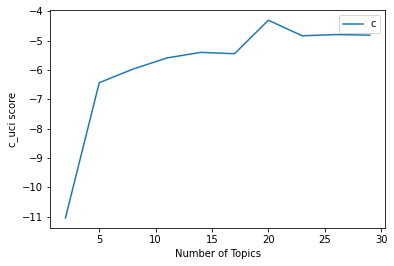

In [ ]:
import matplotlib.pyplot as plt

coherence_score(dictionary=gensim_dictionary, corpus=corpus, texts=fanfic_data["text_processed"], start=2, max=30, step=3)

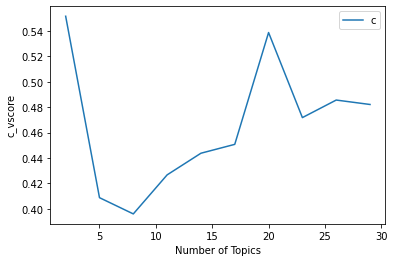

In [ ]:
coherence_score(dictionary=gensim_dictionary, corpus=corpus, texts=fanfic_data["text_processed"], start=2, max=30, step=3, measure="c_v")

На обоих графиках виден совпадающий пик примерно на 20 темах. Тем не менее, если посмотреть на визуализацию расстояние между топиками, то видно, что 20 топиков сильно накладываются друг на друга. Далее будет видно, что 10 тем накладываются менее существенно, поэтому дальнейшая часть работы дублируется для 20 и для 10 топиков.

*В* библиотеке **gensim** есть встроенная интерактивная визаулизация расстояния между темами. Можно использовать ее для того, чтобы оценить насколько пересекаются между собой полученные темы

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [ ]:
vis_20 = gensimvis.prepare(lda_20, corpus, gensim_dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
vis_20

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.070247  0.000781       1        1  15.640646
13     0.027731  0.082017       2        1  10.861211
6     -0.031639  0.008645       3        1   7.619580
15    -0.024168  0.041568       4        1   7.476573
14     0.000699  0.013968       5        1   7.068153
5     -0.106626 -0.126545       6        1   5.408389
1     -0.036356  0.031391       7        1   5.202164
9     -0.013112  0.021358       8        1   5.173361
16     0.158394 -0.050312       9        1   5.079102
19    -0.026319  0.073699      10        1   4.604282
4     -0.023291 -0.069488      11        1   3.772257
10    -0.014431  0.067811      12        1   3.541869
0      0.201208 -0.050771      13        1   3.337142
7     -0.006847  0.003255      14        1   2.916210
18    -0.038897  0.131605      15        1   2.791826
12     0.005908  0.068607      16        1   2.671523
8     -0.032905  0.020062      17        1   2.055332
11     0.212577 -0.108429      18        1   1.923457
17    -0.001667  0.035016      19        1   1.658093
3     -0.180013 -0.194239      20        1   1.198830, topic_info=           Term         Freq        Total Category  logprob  loglift
7066       эмма  3585.000000  3585.000000  Default  30.0000  30.0000
7683     чонгук  3705.000000  3705.000000  Default  29.0000  29.0000
858    гермиона  3249.000000  3249.000000  Default  28.0000  28.0000
7706     стайлз  2487.000000  2487.000000  Default  27.0000  27.0000
7984     тэхить  2361.000000  2361.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
6057  облизнуть    21.543649   137.228633  Topic20  -6.2177   2.5723
1202  оборотень    32.216467   686.395711  Topic20  -5.8153   1.3648
2922      парта    29.431394   567.004066  Topic20  -5.9057   1.4655
7683     чонгук    38.531695  3705.467016  Topic20  -5.6363  -0.1423
4890     цветок    23.581954   448.275865  Topic20  -6.1273   1.4789

[1032 rows x 6 columns], token_table=      Topic      Freq Term
term                      
3208      2  0.038820    2
3208      3  0.038820    2
3208      4  0.067935    2
3208      5  0.097051    2
3208      6  0.019410    2
...     ...       ...  ...
235       8  0.015520    ”
235       9  0.002587    ”
235      10  0.005173    ”
235      13  0.005173    ”
235      14  0.007760    ”

[8490 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 14, 7, 16, 15, 6, 2, 10, 17, 20, 5, 11, 1, 8, 19, 13, 9, 12, 18, 4])

Видно, что большинство тем находятся очень близко друг к другу. Возможно, стоит посмотреть на модель с другим количеством тем, например, с 10.

In [ ]:
lda_10 = gensim.models.LdaMulticore(corpus, 
                                    num_topics=10, 
                                    id2word=gensim_dictionary, 
                                    passes=10, random_state=6457)

2:44: W291 trailing whitespace
3:51: W291 trailing whitespace
4:63: W291 trailing whitespace


In [ ]:
vis_10 = gensimvis.prepare(lda_10, corpus, gensim_dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
vis_10

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.028458  0.006646       1        1  23.072137
0     -0.114160 -0.071728       2        1  12.923334
3     -0.091322  0.072161       3        1  12.151813
7     -0.025096 -0.020506       4        1  10.596280
6      0.050182  0.013111       5        1   9.308082
5      0.179821 -0.014919       6        1   7.909127
1     -0.005987 -0.039774       7        1   7.122593
8     -0.014249  0.102498       8        1   6.849673
4     -0.007423 -0.129758       9        1   5.376038
9     -0.000223  0.082269      10        1   4.690922, topic_info=            Term         Freq        Total Category  logprob  loglift
7683      чонгук  3648.000000  3648.000000  Default  30.0000  30.0000
858     гермиона  3337.000000  3337.000000  Default  29.0000  29.0000
7706      стайлз  2482.000000  2482.000000  Default  28.0000  28.0000
7066        эмма  3631.000000  3631.000000  Default  27.0000  27.0000
80         драко  2671.000000  2671.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
8115       шериф    69.167038   399.769328  Topic10  -6.4155   1.3052
3241    перемена    61.726291   258.481799  Topic10  -6.5294   1.6274
2768      ведьма    81.305210   979.826284  Topic10  -6.2539   0.5704
97          лить    60.791937   256.840840  Topic10  -6.5446   1.6185
1615  тренировка    60.610628   454.366870  Topic10  -6.5476   1.0451

[519 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2750      2  0.989656  industries
6686      1  0.011009         pov
6686      2  0.055043         pov
6686      5  0.220171         pov
6686      7  0.682531         pov
...     ...       ...         ...
235       4  0.767560           ”
235       6  0.002674           ”
235       7  0.042791           ”
235       8  0.139070           ”
235      10  0.013372           ”

[3049 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 8, 7, 6, 2, 9, 5, 10])

Темы уже не налезают друг на друга так сильно. Можно использовать обе модели - на 10 и на 20 тем, дальнейшие операции будут для них одинаковы.

Теперь необходимо назначить каждому документу в нашем копусе наиболее подходящую (наиболее вероятную) для него тему. Для удобства лучше разделить тему документа и ее вероятность в разные колонки.

In [ ]:
def get_topic(words, lda):
    """
    Функция назначает документу наиболее вероятный топик
    :param words: лемматизированный текст документа
    :param lda: тематическая модель
    :return: список из наиболее вероятного топика 
    и его вероятности
    """
    bag = lda.id2word.doc2bow(words)
    topics = lda.get_document_topics(bag)
    topic_dictionary = {}
    for topic in topics:
        topic_dictionary[topic[1]] = str((topic[0])) 
    main_probability = max(topic_dictionary)
    main_topic = topic_dictionary[main_probability]
    
    return [main_topic, main_probability]

In [ ]:
fanfic_data["lda_20"] = fanfic_data["text_processed"].apply(get_topic, 
                                                            lda=lda_20)

In [ ]:
fanfic_data["topic_20"] = fanfic_data["lda_20"].str[0]
fanfic_data["probability_20"] = fanfic_data["lda_20"].str[1]
del fanfic_data["lda_20"]
fanfic_data.head()

,Unnamed: 0,id,author,title,link,description,tag,likes,date,review,size,text,rating,parts,romance,fandom,genre,page,text_processed,standart_fandom,topic,probability,topic_20,probability_20
0,0,1,Olivia,Герои недописанных историй,/readfic/1920934,"Герои недописанных историй,\r\nзамерзшие во л...","Ангст,Драма,Стихи",13474,2014-04-28,1118,162,"Герои недописанных историй,\r\nЗамерзшие во ль...",G,Нет,Джен,Ориджиналы,Ангст,1,"[герой, недописанный, история, замёрзнуть, лёд...",Ориджиналы,10,0.602122,10,0.602013
1,1,2,Джoкер,О войне писали много,/readfic/1743853,"Прах от тел, скелеты зданий,\r\nЛес сгоревший ...","Ангст,Драббл,Стихи",6621,2014-03-05,432,138,"О войне писали много,\r\nКак летит на землю пл...",G,Нет,Джен,Ориджиналы,Ангст,1,"[война, писать, лететь, земля, пламень, миг, с...",Ориджиналы,0,0.620104,0,0.620003
2,2,3,лунный мечтатель полтергейста,Невыносимое создание,/readfic/8603938,У мальчишки Поттера глаза его деда и та же при...,"AU,Ангст,Детская влюбленность,Дружба,Наставнич...",5398,2019-09-03,97,1586,- Ты! Ты украл у меня слугу! \r\n Л...,PG-13,Нет,Джен,"Роулинг Джоан «Гарри Поттер»,Гарри Поттер",Ангст,1,"[украсть, слуга, люциус, хвататься, палочка, ж...",Гарри Поттер,13,0.749004,13,0.749010
3,3,4,Хана_Вишнёвая,Ангелы падают,/readfic/1119388,Серый асфальт – конечная.,"Ангст,Драббл,Стихи,Эксперимент",5217,2013-08-19,181,127,Ангелы падают.\r\nАнгелы падают вниз.\r\nКрыль...,G,Нет,Джен,Ориджиналы,Ангст,1,"[ангел, падать, ангел, падать, крыло, держать,...",Ориджиналы,12,0.771649,12,0.771711
4,4,5,LuckyLuke,Меня зовут Сэм,/readfic/3911101,"Меня зовут Сэм. Вернее, звали - в последней жи...","Hurt/Comfort,Ангст,Соулмейты,Эксперимент",4883,2015-12-29,403,3432,"Меня зовут Сэм. Вернее, звали — в последней жи...",R,Нет,Джен,Ориджиналы,Ангст,1,"[звать, сэм, верный, звать, последний, жизнь, ...",Ориджиналы,2,0.422447,2,0.422484


In [ ]:
fanfic_data["lda_10"] = fanfic_data["text_processed"].apply(get_topic, 
                                                            lda=lda_10)

2:71: W291 trailing whitespace


In [ ]:
fanfic_data["topic_10"] = fanfic_data["lda_10"].str[0]
fanfic_data["probability_10"] = fanfic_data["lda_10"].str[1]
del fanfic_data["lda_10"]

fanfic_data.head()

In [ ]:
fanfic_data.describe()

,Unnamed: 0,id,likes,review,size,page,probability,probability_20,probability_10
count,1600.000000,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,49.500000,50.500000,3467.15375,82.578750,4438.070625,3.000000,0.683526,0.683574,0.749689
std,28.875095,28.875095,3728.00247,113.760548,5471.806264,1.414656,0.216407,0.216353,0.199318
min,0.000000,1.000000,148.00000,0.000000,3.000000,1.000000,0.050000,0.050000,0.100000
25%,24.750000,25.750000,1149.00000,22.000000,1484.500000,2.000000,0.512735,0.512739,0.588682
50%,49.500000,50.500000,2239.50000,52.000000,2734.000000,3.000000,0.680034,0.680424,0.755785
75%,74.250000,75.250000,4562.25000,104.000000,5140.500000,4.000000,0.871079,0.870500,0.953182
max,99.000000,100.000000,45435.00000,1967.000000,65620.000000,5.000000,0.999856,0.999856,0.999864


Теперь можно перейти к самому ответу на вопрос, как связаны жанр и фандом фанфика с его содержанием. Построим график, где по горизонтале отложены жанры,а по вертикали - темы. ДЛя этого импортируем библиотеку **seaborn**

In [ ]:
import seaborn as sns

sns.catplot(x="genre", y="topic_20", kind="swarm", data=fanfic_data, height=5,
            aspect=3)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 20.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 23.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 33.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


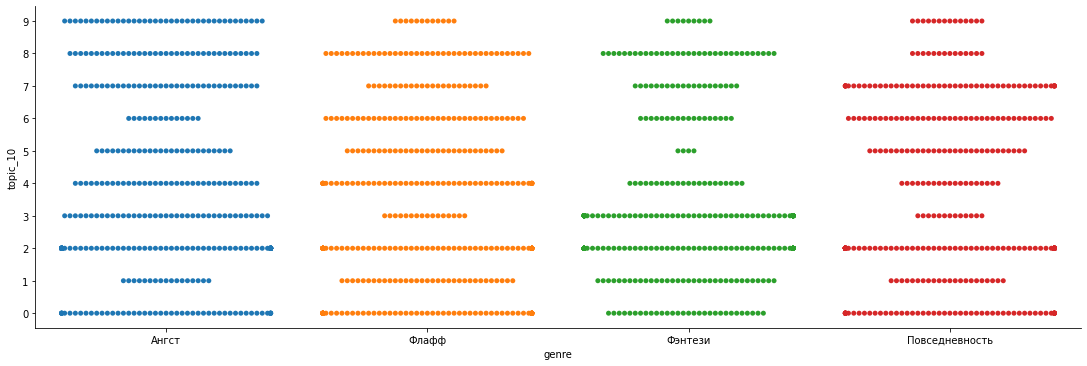

In [ ]:
sns.catplot(x="genre", y="topic_10", kind="swarm",data=fanfic_data, height=5,
            aspect=3)

Видно, что жанры распределяются по темам более-менее равномерно. Теперь посмотрим, как соотносятся с темами стандартизованные фандомы

In [ ]:
sns.catplot(x="standart_fandom", y="topic_20", kind="strip", data=fanfic_data,
            height=5, aspect=6)

In [ ]:
sns.catplot(x="standart_fandom", y="topic_10", kind="strip", data=fanfic_data,
            height=5, aspect=6)

Видно, что, во-первых, фандом "ориджиналы" и "прочее" (низкочастотные фандомы) распределяются по темам равномернее всего. Остальные фандомы преобладающе связаны с одной-двумя темами. Далее можно посмотрить и связь возрастного рейтинга и направленности фанфиков с темами

In [ ]:
sns.catplot(x="rating", y="topic_20", kind="swarm", data=fanfic_data, height=5,
            aspect=3)

In [ ]:
sns.catplot(x="rating", y="topic_10", kind="swarm", data=fanfic_data, height=5,
            aspect=3)

In [ ]:
sns.catplot(x="romance", y="topic_20", kind="swarm", data=fanfic_data,
            height=5, aspect=3)

Среди тем можно было заметить одну, по всей видимости связанную с жанром "омегаверс". Вот как "Книга фанфиков" определяет этот жанр:“Действие работы происходит в мире, где персонажи распределены на три типа: альфы, беты и омеги, каждый из которых обладает рядом физиологических особенностей, сексуальных пристрастий, определенным положением в социальной иерархии и т.д.”.   А вот тема  среди 10 тем, которая очень на него напоминает:   **('0.021*"альфа" + 0.020*"омег" + 0.019*"альф" + 0.018*"омега" + 0.008*"течка" + 0.007*"бета" + 0.007*"виктор" + 0.004*"крис" + 0.004*"гермиона" + 0.003*"марк"')**. Фанфики этого жанра имееют указание на него среди своих меток. Интересно проверить, действительно ли омегаверс связан с определенной темой (темами). Для того, чтобы этого выяснить, сначала нужно выделить метку Омегаверса в отдельную колонку (присутствует ли она среди меток фанфика или нет)


In [ ]:
def omega(data):
    """
    Функция выдает строку Омегаверс, если Омегаверс присутствует
    в списке тегов и строку Не омегаверс, если отсутствует
    :param data: список тегов
    :return: строка Омегаверс или строка Не омегаверс
    """
    omega = ""
    if "Омегаверс" in data:
        omega = "Омегаверс"
    else:
        omega = "Не омегаверс"
    return omega

In [ ]:
fanfic_data["Omega"] = fanfic_data["tag"].apply(omega)
fanfic_data.head()

Теперь можно построить график и посмотреть, как распределяются фанфики омагеверс и не омегаверс относительно тем

In [ ]:
sns.catplot(x="Omega", y="topic_10", kind="strip", data=fanfic_data, height=5,
            aspect=3)

NameError: ignored

In [ ]:
sns.catplot(x="Omega", y="topic_20", kind="strip", data=fanfic_data, height=5,
            aspect=3)

Видно, что омегаверс преимущественно связан с несколькими темами. Можно сделать вывод, что, хотя те жанры, которые мы выбрали, мало связаны с конкретными темами, есть жанры, которые с ними связаны. Важно сделать уточнение - если посмотреть на выделившиеся темы, то легко увидеть, насколько много там встречаются имен. В дальнейшем, было бы полезно сделать тематическое моделирование, предварительно удалив именные сущности из текста, но здесь мы пока заниматься этим не будем